## Import

In [1]:
# import libraries
import torch
import numpy as np
import torch.nn.functional as nnf
from torchvision import datasets
import torchvision.transforms as transforms
from IPython import display
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.pyplot import axhline, axvline, grid, style
import seaborn
import cv2

seaborn.set(style='ticks')
style.use('seaborn')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

px = 1/plt.rcParams['figure.dpi']  # inches to pixels

## Data

In [2]:
%matplotlib inline
batch = 30
transform = transforms.ToTensor()

dataTrain = datasets.MNIST(root='data', train=True, download=True, transform=transform)

loaderTrain = torch.utils.data.DataLoader(dataTrain, batch_size=batch, num_workers= 0)


## Data Sample

<ipython-input-3-c78362dba8c4>:6: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(4, 20/4, i+1, xticks=[], yticks=[])


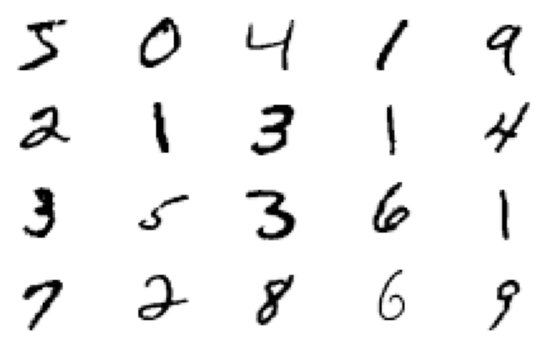

In [3]:
   
it = iter(loaderTrain)
images, labels = it.next()
images = images.numpy()
fig = plt.figure(figsize=(10, 6))
for i in range(0, 20):
    ax = fig.add_subplot(4, 20/4, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[i]), cmap='Greys')    

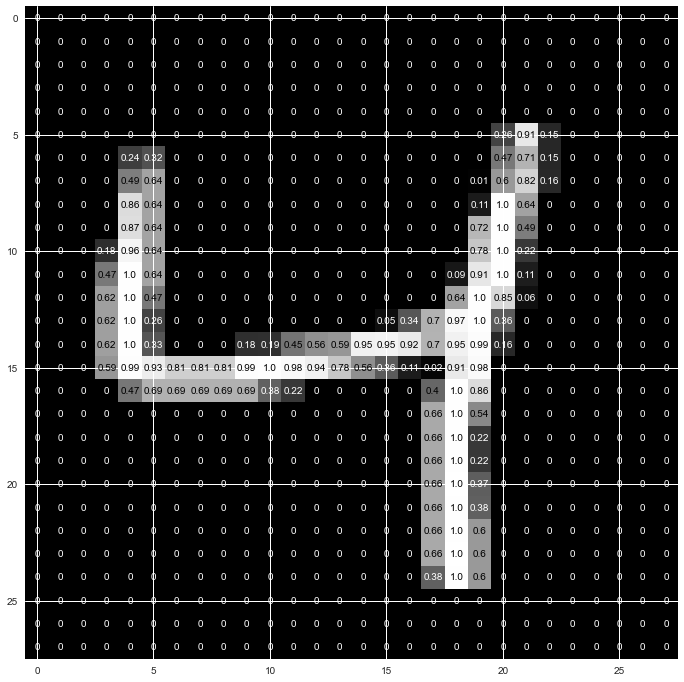

In [4]:
img = np.squeeze(images[2])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x), horizontalalignment='center', verticalalignment='center', color='white' if img[x][y]<thresh else 'black')

## Model

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(p=.5)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = F.log_softmax(self.fc3(x), dim=1)
        return x

model = Net()

In [6]:
criterion = nn.NLLLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

In [7]:
%matplotlib inline

epochs = 30
model.to(device)
model.train()

yloss = np.zeros(epochs)

for epoch in range(epochs):
    lossLabel = 0.0    
    for data, target in loaderTrain:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()        

        output = model(data)
        
        loss = criterion(output, target)

        loss.backward()
        
        optimizer.step()

        lossLabel += loss.item()*data.size(0)
            
    lossLabel = lossLabel/len(loaderTrain.dataset)
    yloss[epoch] = lossLabel
    display.clear_output(wait=True)
    print('Epoch: {} \tLoss: {:.6f}'.format(epoch+1, lossLabel))
    

Epoch: 30 	Loss: 0.156905


## Loss Plot

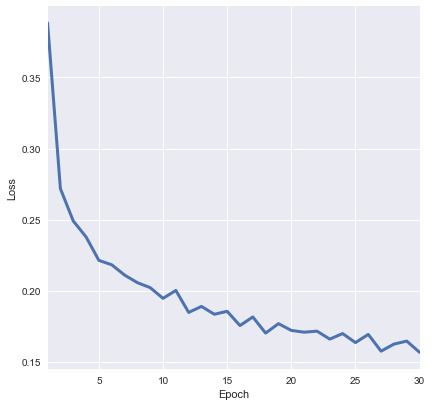

In [8]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(480*px, 480*px))

epochsX = np.arange(1, epochs+1)

ax.set(xlim=(1, epochs))
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.plot(epochsX, yloss , 'b-', lw=3)

plt.show()

In [9]:
# torch.save(model, 'model_char.pth')

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
model = torch.load('model_char.pth')
model.eval()

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [11]:
 %matplotlib tk
 
drawing = False
pt1X , pt1Y = None , None
imgResult = np.zeros((512,512,1), np.uint8)
model.eval()

def TestDraw(testImage):
    char = 0    
    output = model(testImage.to(device))    
    prob = nnf.softmax(output, dim=1)
    top_p, top_class = prob.topk(1, dim = 1)   

    return top_class.item(), top_p.item() #class and score

def ClearDraw():    
    img[:,:,:] = 0    

# mouse callback
def line_drawing(event,x,y,flags,param):
    global pt1X,pt1Y,drawing

    if event==cv2.EVENT_LBUTTONDOWN:
        drawing=True
        pt1X,pt1Y=x,y

    elif event==cv2.EVENT_MOUSEMOVE:
        if drawing==True:
            cv2.line(img,(pt1X,pt1Y),(x,y),color=(255,255,255),thickness=35)
            pt1X,pt1Y=x,y

            # Resize and test agains the model      
            imgResized = cv2.resize(img, (28, 28),interpolation=cv2.INTER_CUBIC)
            dst = cv2.GaussianBlur(imgResized,(3,3),cv2.BORDER_DEFAULT)
            imgResized = cv2.normalize(imgResized, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
            _image = np.array(imgResized)
            image = torch.from_numpy(_image)
            image = image[np.newaxis, :] 
            imgTensor = torch.FloatTensor(imgResized)                               
            top, confidence = TestDraw(imgTensor)

            # Clear
            imgResult[:,:,:] = 0                
            text = "Recognized: %d" % top
            cv2.putText(imgResult, text, (xText, yText), font, font_size, font_color, font_thickness, cv2.LINE_AA)                           
            text = "Confidence: %.2f" % confidence
            cv2.putText(imgResult, text, (xText, yText+30), font, font_size, font_color, font_thickness, cv2.LINE_AA)    
            cv2.imshow('Result',imgResult)
           
    elif event==cv2.EVENT_LBUTTONUP:
        drawing=False
        cv2.line(img,(pt1X,pt1Y),(x,y),color=(255,255,255),thickness=35)             


img = np.zeros((512,512,1), np.uint8)
cv2.namedWindow('Test Char')
cv2.resizeWindow('Test Char', 512, 512)
cv2.setMouseCallback('Test Char',line_drawing)

cv2.namedWindow('Result', cv2.WINDOW_KEEPRATIO)
cv2.resizeWindow('Result', 512, 512)

color = (255,255,255)
font = cv2.FONT_HERSHEY_SIMPLEX
font_size = 1
font_color = color
font_thickness = 2
xText,yText = 30,30    

while(1):
    k = cv2.waitKey(33)
    if(k == 27): # esc        
        break
    elif k == ord('c'):    
        ClearDraw()   
    cv2.imshow('Test Char',img)
 
cv2.destroyAllWindows()